In [2]:
%matplotlib inline

Analyze Visium fluorescence data
================================

This tutorial shows how to apply Squidpy image analysis features for the
analysis of Visium data.

For a tutorial using Visium data that includes the graph analysis
functions, have a look at
sphx\_glr\_auto\_tutorials\_tutorial\_visium\_hne.py. The dataset used
here consists of a Visium slide of a coronal section of the mouse brain.
The original dataset is publicly available at the 10x genomics [dataset
portal](https://support.10xgenomics.com/spatial-gene-expression/datasets)
. Here, we provide a pre-processed dataset, with pre-annotated clusters,
in anndata.AnnData format and the tissue image in
squidpy.im.ImageContainer format.

A couple of notes on pre-processing:

-   The pre-processing pipeline is the same as the one shown in the
    original [Scanpy
    tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html)
    .
-   The cluster annotation was performed using several resources, such
    as the [Allen Brain
    Atlas](http://mouse.brain-map.org/experiment/thumbnails/100048576?image_type=atlas)
    , the [Mouse Brain gene expression
    atlas](http://mousebrain.org/genesearch.html) from the Linnarson lab
    and this recent pre-print linnarson2020.

Import packages & data
----------------------

To run the notebook locally, create a conda environment as *conda create
-f environment.yml* using this
[environment.yml](https://github.com/theislab/squidpy_notebooks/blob/master/environment.yml)


In [1]:
import scanpy as sc
import anndata as ad
import squidpy as sq

import pandas as pd

import matplotlib.pyplot as plt

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

# load the pre-processed dataset
img = sq.datasets.visium_fluo_image_crop()
adata = sq.datasets.visium_fluo_adata_crop()

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.2 scipy==1.6.2 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.1 leidenalg==0.8.3
squidpy==1.0.0


  0%|          | 0.00/303M [00:00<?, ?B/s]

  0%|          | 0.00/65.5M [00:00<?, ?B/s]

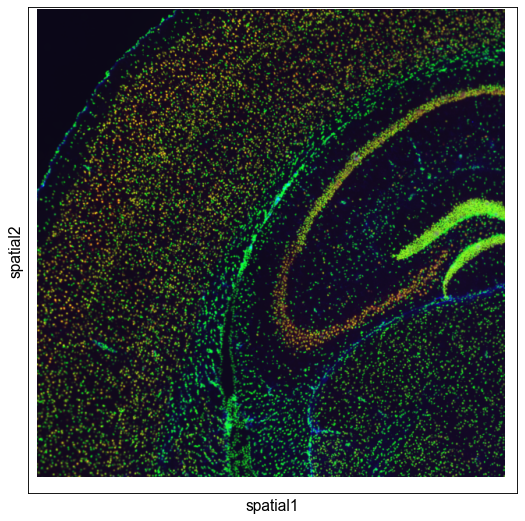

In [22]:
sc.pl.spatial(adata)

First, let's visualize the cluster annotation in the spatial context
with scanpy.pl.spatial.

As you can see, this dataset is a smaller crop of the whole brain
section. We provide this crop to make the execution time of this
tutorial a bit shorter.


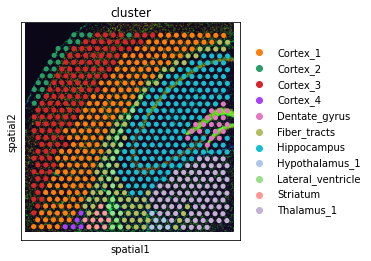

In [3]:
sc.pl.spatial(adata, color="cluster")

The fluorescence image provided with this dataset has three channels:
*DAPI* (specific to DNA), *anti-NEUN* (specific to neurons), *anti-GFAP*
(specific to Glial cells). We can directly visualize the channels with
the method squidpy.im.ImageContainer.show.


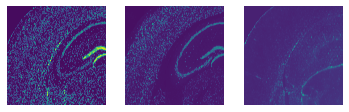

In [4]:
fig, axes = plt.subplots(1, 3)
for i, ax in enumerate(axes):
    img.show(channel=i, ax=ax)

Visium datasets contain high-resolution images of the tissue. Using the
function squidpy.im.calculate\_image\_features you can calculate image
features for each Visium spot and create a `obs x features` matrix in
`adata` that can then be analyzed together with the `obs x gene` gene
expression matrix.

By extracting image features we are aiming to get both similar and
complementary information to the gene expression values. Similar
information is for example present in the case of a tissue with two
different cell types whose morphology is different. Such cell type
information is then contained in both the gene expression values and the
tissue image features. Complementary or additional information is
present in the fact that we can use a nucleus segmentation to count
cells and add features summarizing the immediate spatial neighborhood of
a spot.

Squidpy contains several feature extractors and a flexible pipeline of
calculating features of different scales and sizes. There are several
detailed examples of how to use squidpy.im.calculate\_image\_features.
sphx\_glr\_auto\_examples\_image\_compute\_features.py provides a good
starting point for learning more.

Here, we will extract summary, histogram, segmentation, and texture
features. To provide more context and allow the calculation of
multi-scale features, we will additionally calculate summary and
histogram features at different crop sizes and scales.

Image segmentation
==================

To calculate segmentation features, we first need to segment the tissue
image using squidpy.im.segment. But even before that, it's best practice
to pre-process the image by e.g. smoothing it using in
squidpy.im.process. We will then use the *DAPI* channel of the
fluorescence image (`channel_ids=0`). Please refer to
sphx\_glr\_auto\_examples\_image\_compute\_segment\_fluo.py for more
details on how to calculate a segmented image.


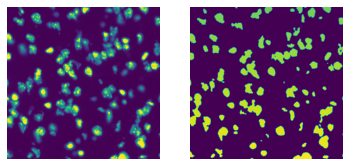

In [6]:
sq.im.process(
    img=img,
    layer="image",
    method="smooth",
)

sq.im.segment(img=img, layer="image_smooth", method="watershed", channel_ids=0, xs=1000, ys=1000)

# plot the resulting segmentation
fig, ax = plt.subplots(1, 2)
img_crop = img.crop_corner(2000, 2000, size=500)
img_crop.show(layer="image", channel=0, ax=ax[0])
img_crop.show(
    layer="segmented_watershed",
    channel=0,
    ax=ax[1],
)

The result of squidpy.im.segment is saved in
`img['segmented_watershed']` by default. It is a label image where each
segmented object is annotated with a different integer number.

Segmentation features
=====================

We can now use the segmentation to calculate segmentation features.
These include morphological features of the segmented objects and
channel-wise image intensities beneath the segmentation mask. In
particular, we can count the segmented objects within each Visium spot
to get an approximation of the number of cells. In addition, we can
calculate the mean intensity of each fluorescence channel within the
segmented objects. Depending on the fluorescence channels, this can give
us e.g., an estimation of the cell type. For more details on how the
segmentation features, you can have a look at the docs of
squidpy.im.calculate\_image\_features or the example at
sphx\_glr\_auto\_examples\_image\_compute\_segmentation\_features.py.


In [11]:
adata.obsm['features_segmentation']

,segmentation_label,segmentation_area_mean,segmentation_area_std,segmentation_ch-0_mean_intensity_mean,segmentation_ch-0_mean_intensity_std,segmentation_ch-1_mean_intensity_mean,segmentation_ch-1_mean_intensity_std,segmentation_ch-2_mean_intensity_mean,segmentation_ch-2_mean_intensity_std
AAACGAGACGGTTGAT-1,13,297.846154,341.137204,41745.553007,10726.124669,6409.883390,3650.437036,9211.208493,612.745540
AAAGGGATGTAGCAAG-1,28,73.035714,105.721833,46320.957080,13145.281305,11521.385469,11692.212179,9803.006836,1114.498916
AAATGGCATGTCTTGT-1,22,132.727273,197.747355,33396.599837,5352.654032,13921.337464,11227.618557,7992.814924,2847.676516
AAATGGTCAATGTGCC-1,15,225.733333,233.265933,37803.390640,7846.833913,3663.273641,210.312098,9696.696951,1242.953480
AAATTAACGGGTAGCT-1,6,341.333333,213.474172,41855.115400,7902.668838,11624.054143,9189.187745,10321.500573,2874.930942
...,...,...,...,...,...,...,...,...,...
TTGTCGTTCAGTTACC-1,29,486.689655,1244.456982,51492.345710,13472.410402,4101.184556,562.744658,25800.970617,19687.465670
TTGTGGCCCTGACAGT-1,29,170.344828,183.291228,35105.699606,5893.358414,14678.391303,9906.205295,8660.097394,1731.677369
TTGTTAGCAAATTCGA-1,35,177.571429,208.876626,35064.453679,7068.893544,18537.407158,11194.469628,7064.686776,281.678670
TTGTTCAGTGTGCTAC-1,7,58.428571,115.370035,46503.281807,12551.160561,4563.934715,322.966867,9516.684338,923.152388


  0%|          | 0/704 [00:00<?, ?/s]

c:\users\sai\anaconda3\envs\squidpy\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


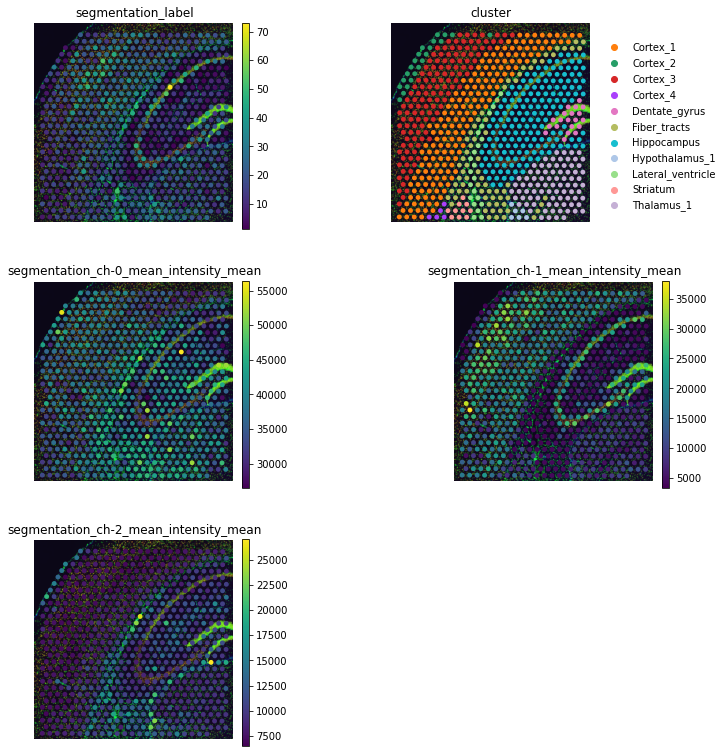

In [12]:
# define image layer to use for segmentation
features_kwargs = {"segmentation": {"label_layer": "segmented_watershed"}}
# calculate segmentation features
sq.im.calculate_image_features(
    adata,
    img,
    features="segmentation",
    layer="image",
    key_added="features_segmentation",
    n_jobs=1,
    features_kwargs=features_kwargs,
)
# plot results and compare with gene-space clustering
sc.pl.spatial(
    sq.pl.extract(adata, "features_segmentation"),
    color=[
        "segmentation_label",
        "cluster",
        "segmentation_ch-0_mean_intensity_mean",
        "segmentation_ch-1_mean_intensity_mean",
        "segmentation_ch-2_mean_intensity_mean"
    ],
    frameon=False,
    ncols=2,
)

Above, we made use of squidpy.pl.extract, a method to extract all
features in a given adata.obsm\['{key}'\] and temporarily save them to
anndata.AnnData.obs. Such method is particularly useful for plotting
purpose, as shown above.

The number of cells per Visium spot provides an interesting view of the
data that can enhance the characterization of gene-space clusters. We
can see that the cell-rich pyramidal layer of the Hippocampus has more
cells than the surrounding areas (upper left). This fine-grained view of
the Hippocampus is not visible in the gene clusters where the
Hippocampus is one cluster only.

The per-channel intensities plotted in the second row show us that the
areas labeled with *Cortex\_1* and *Cortex\_3* have a higher intensity
of channel 1, *anti-NEUN* (lower left). This means that these areas have
more neurons that the remaining areas in this crop. In addition, cluster
*Fiber\_tracts* and *lateral ventricles* seems to be enriched with
*Glial cells*, seen by the larger mean intensities of channel 2,
*anti-GFAP*, in these areas (lower right).

Extract and cluster features
============================

Now we will calculate summary, histogram, and texture features. These
features provide a useful compressed summary of the tissue image. For
more information on these features, refer to:

-   sphx\_glr\_auto\_examples\_image\_compute\_summary\_features.py.
-   sphx\_glr\_auto\_examples\_image\_compute\_histogram\_features.py.
-   sphx\_glr\_auto\_examples\_image\_compute\_texture\_features.py.



In [13]:
# define different feature calculation combinations
params = {
    # all features, corresponding only to tissue underneath spot
    "features_orig": {
        "features": ["summary", "texture", "histogram"],
        "scale": 1.0,
        "mask_circle": True,
    },
    # summary and histogram features with a bit more context, original resolution
    "features_context": {"features": ["summary", "histogram"], "scale": 1.0},
    # summary and histogram features with more context and at lower resolution
    "features_lowres": {"features": ["summary", "histogram"], "scale": 0.25},
}

for feature_name, cur_params in params.items():
    # features will be saved in `adata.obsm[feature_name]`
    sq.im.calculate_image_features(adata, img, layer="image", key_added=feature_name, n_jobs=1, **cur_params)

# combine features in one dataframe
adata.obsm["features"] = pd.concat([adata.obsm[f] for f in params.keys()], axis="columns")

# make sure that we have no duplicated feature names in the combined table
adata.obsm["features"].columns = ad.utils.make_index_unique(adata.obsm["features"].columns)

  0%|          | 0/704 [00:00<?, ?/s]

  0%|          | 0/704 [00:00<?, ?/s]

  0%|          | 0/704 [00:00<?, ?/s]

In [19]:
for key in adata.obsm.keys():
    if "features" in key:
        print(key, adata.obsm[key].shape)

features_segmentation (704, 9)
features_orig (704, 105)
features_context (704, 45)
features_lowres (704, 45)
features (704, 195)


We can use the extracted image features to compute a new cluster
annotation. This could be useful to gain insights in similarities across
spots based on image morphology.

For this, we first define a helper function to cluster features.


In [20]:
def cluster_features(features: pd.DataFrame, like=None):
    """Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(10, features.shape[1] - 1))
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata.obs["leiden"]

Then, we calculate feature clusters using different features and compare
them to gene clusters


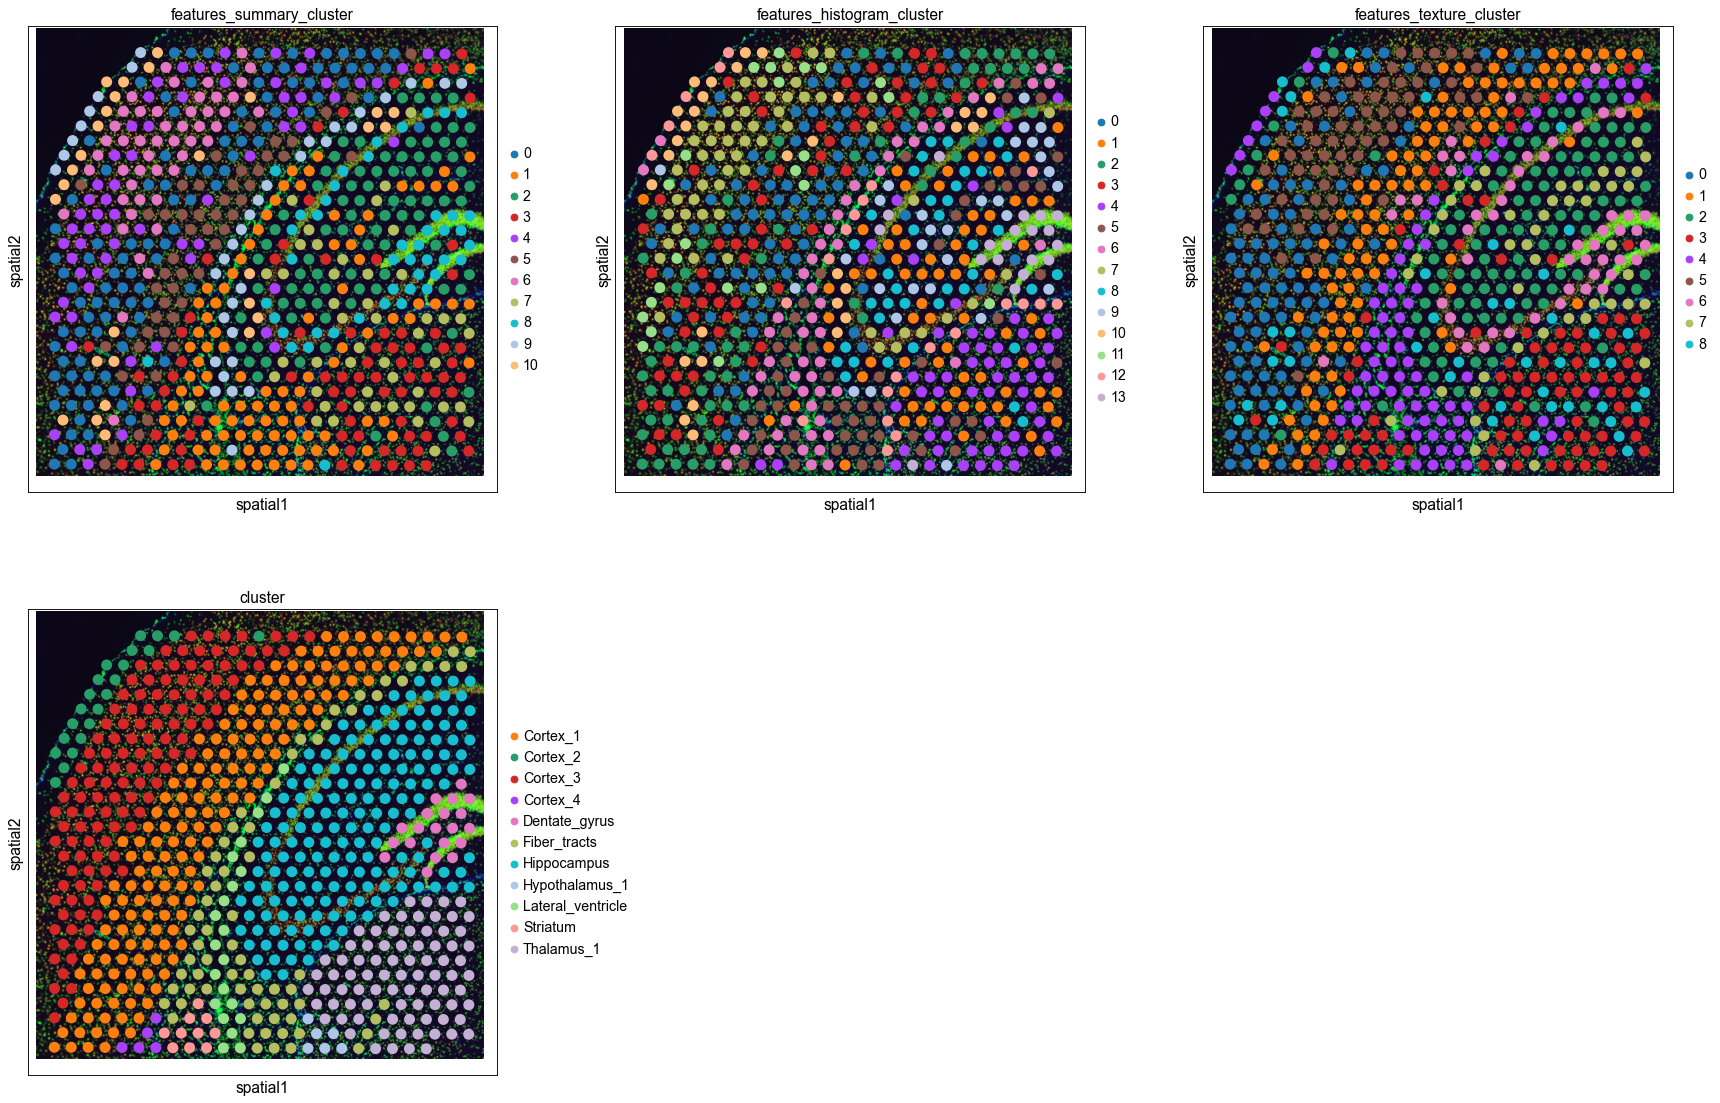

In [21]:
adata.obs["features_summary_cluster"] = cluster_features(adata.obsm["features"], like="summary")
adata.obs["features_histogram_cluster"] = cluster_features(adata.obsm["features"], like="histogram")
adata.obs["features_texture_cluster"] = cluster_features(adata.obsm["features"], like="texture")

sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.pl.spatial(
    adata,
    color=[
        "features_summary_cluster",
        "features_histogram_cluster",
        "features_texture_cluster",
        "cluster",
    ],
    ncols=3,
)

Like the gene-space clusters (bottom middle), the feature space clusters
are also spatially coherent.

The feature clusters of the different feature extractors are quite
diverse, but all of them reflect the structure of the hippocampus by
assigning different clusters to the different structural areas. This is
a higher level of detail than the gene-space clustering provides with
only one cluster for the hippocampus.

The feature clusters also show the layered structure of the cortex, but
again subdividing it in more clusters than the gene-space clustering. It
might be possible to re-cluster the gene expression counts with a higher
resolution to also get more fine-grained clusters, but nevertheless the
image features seem to provide additional supporting information to the
gene-space clusters.
